# Ziyi Gong

# Firing Rate Adaptation and Competition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from numba import jit, int32, float64
plt.rc('text', usetex=True)
plt.rc('font', size=20)

In [2]:
# const
theta = -0.1
K = 0.1
tau_r = 1.0
tau_a = 100.0

Is = (0.2, 0.7)
gs = (0.1, 0.7)

dt = 0.1
tmax = 1000
t = np.arange(0, tmax + dt, dt)

In [3]:
@jit(nopython=True)
def S(x):
    return 1 / (1 + np.exp(-(x - theta) / K))

## 1a

In [4]:
@jit
def sim1(I, g):
    # init
    r = np.zeros(t.shape, dtype='float64')
    a = np.zeros(t.shape, dtype='float64')
    for i in range(1, t.shape[0]):
        r[i] = r[i-1] + dt * (-r[i-1] + S(I - g * a[i-1])) / tau_r
        a[i] = a[i-1] + dt * (-a[i-1] + r[i-1]) / tau_a
    return r, a

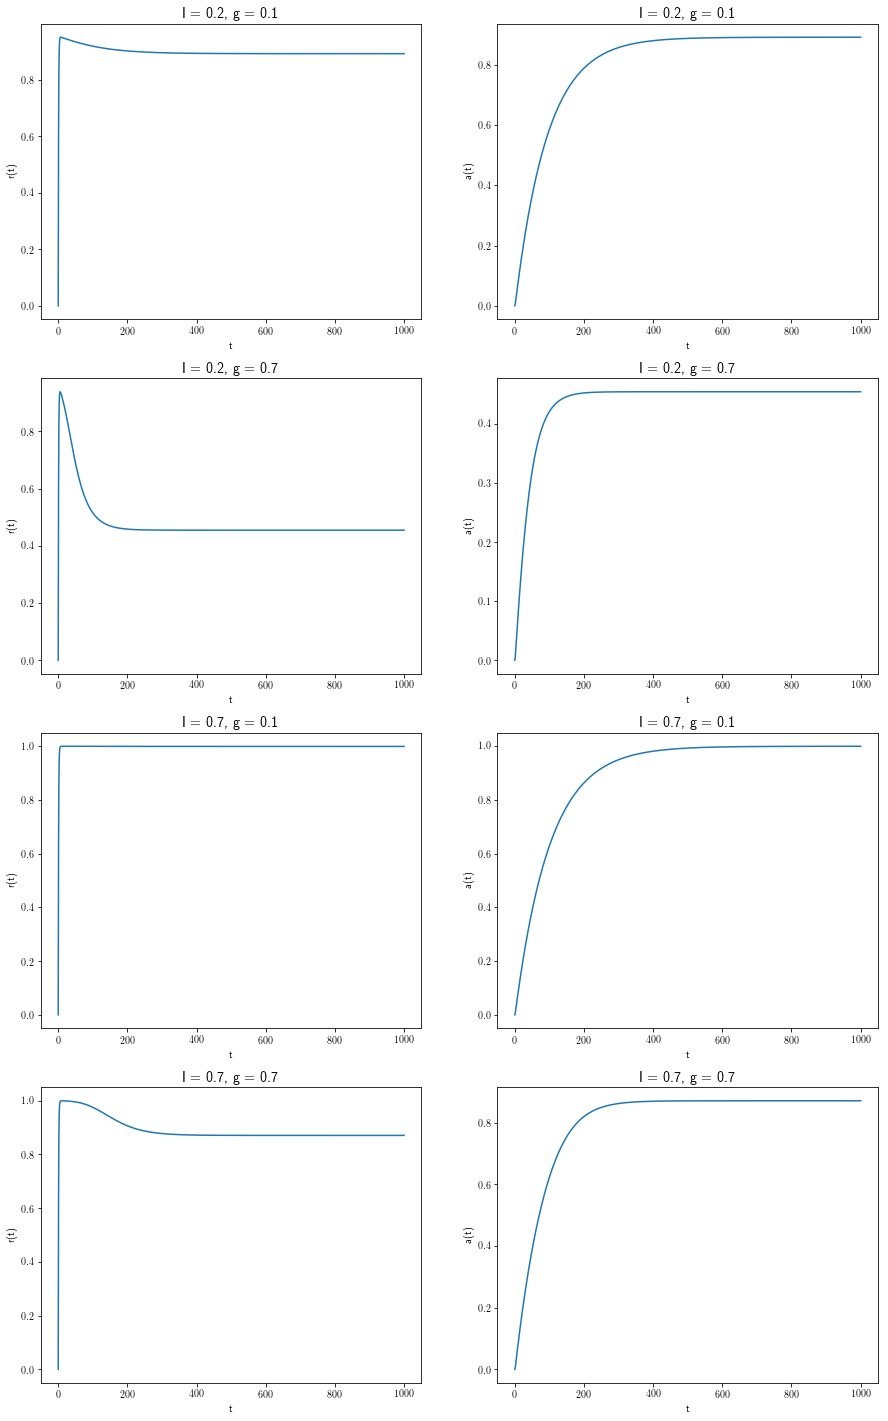

In [5]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches((15, 25))
plt.rc('font', size=12)
plt.rc('axes', labelsize=12)
for i, (I, g) in enumerate(product(Is, gs)):
    r, a = sim1(I, g)
    title = 'I = {}, g = {}'.format(I, g)
    ax[i, 0].plot(t, r)
    ax[i, 0].set_xlabel('t')
    ax[i, 0].set_ylabel('r(t)')
    ax[i, 0].set_title(title)
    ax[i, 1].plot(t, a)
    ax[i, 1].set_xlabel('t')
    ax[i, 1].set_ylabel('a(t)')
    ax[i, 1].set_title(title)

### Fig. 1: Firing rates and adaptation currents with different input current, I, and overall adaptation gain, g.

## 1b

In [6]:
@jit(nogil=True)
def sim2():
    rs = np.zeros([101, 101], dtype='float64')
    for I in range(101):
        for g in range(101):
            a = 0
            for i in range(1, t.shape[0]):
                rs[I, g] = rs[I, g] + dt * (-rs[I, g] + S(I - g * a)) / tau_r
                a = a + dt * (-a + rs[I, g]) / tau_a
    return rs

Text(0, 0.5, 'I')

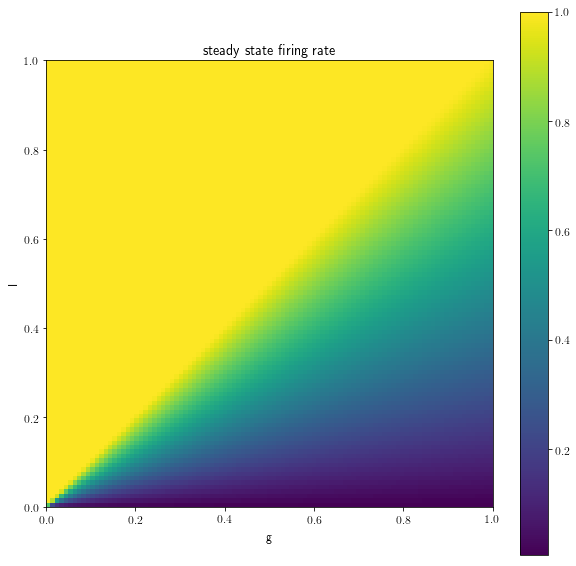

In [7]:
rs = sim2()
plt.figure(figsize=(10,10))
plt.imshow(rs, origin='lower', extent=[0, 1, 0, 1])
plt.title('steady state firing rate')
plt.colorbar()
plt.xlabel('g')
plt.ylabel('I')

### Fig. 2: Increasing the overall adaptation gain, g, decreases the steady firing rate and increasing the input current, I, increases the steady state firing rate. 

## 1c

In [8]:
tmax = 1500
t = np.arange(0, tmax + dt, dt)

In [9]:
# const 
g = 0.5

ws = (0.3, 0.0)
Is = ((0.2, 0.7), (0.5, 0.5))

In [10]:
@jit
def sim3(I1, I2, w):
    # init
    r1 = np.zeros(t.shape, dtype='float64')
    a1 = np.zeros(t.shape, dtype='float64')
    r2 = np.zeros(t.shape, dtype='float64')
    a2 = np.zeros(t.shape, dtype='float64')
    
    r2[0] = 0.01
    for i in range(1, t.shape[0]):
        r1[i] = r1[i-1] + dt * (-r1[i-1] + S(I1 - g * a1[i-1] - w * r2[i-1])) / tau_r
        a1[i] = a1[i-1] + dt * (-a1[i-1] + r1[i-1]) / tau_a
        r2[i] = r2[i-1] + dt * (-r2[i-1] + S(I2 - g * a2[i-1] - w * r1[i-1])) / tau_r
        a2[i] = a2[i-1] + dt * (-a2[i-1] + r2[i-1]) / tau_a
    return r1, r2

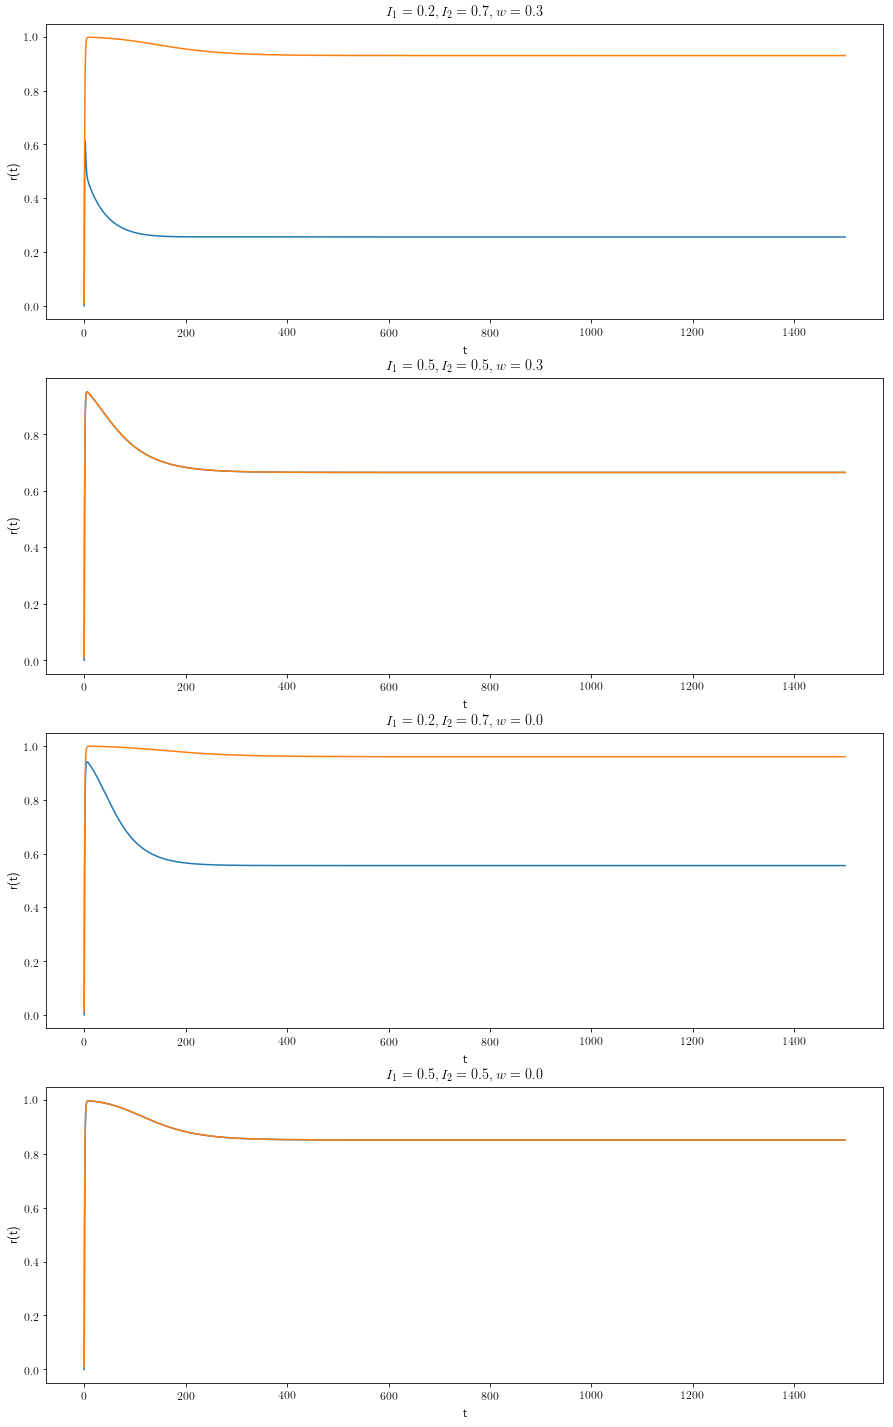

In [11]:
fig, ax = plt.subplots(4, 1)
fig.set_size_inches((15, 25))

for i, (w, (I1, I2)) in enumerate(product(ws, Is)):
    r1, r2 = sim3(I1, I2, w)
    title = r'$I_1 = {}, I_2 = {}, w = {}$'.format(I1, I2, w)
    ax[i].plot(t, r1)
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('r(t)')
    ax[i].set_title(title)
    ax[i].plot(t, r2)

### Fig. 3: For this graph and the following graphs related to $r_1$ and $r_2$, the blue one is $r_1$, and the orange one is $r_2$. When the input currents are the same, they have exactly the same firing rate all the time. When the input currents are not the same, the one with the smaller input initially reaches a maximum firing rate, which is proportional to the inhibition weight, w, and then goes down soon.

## 1d

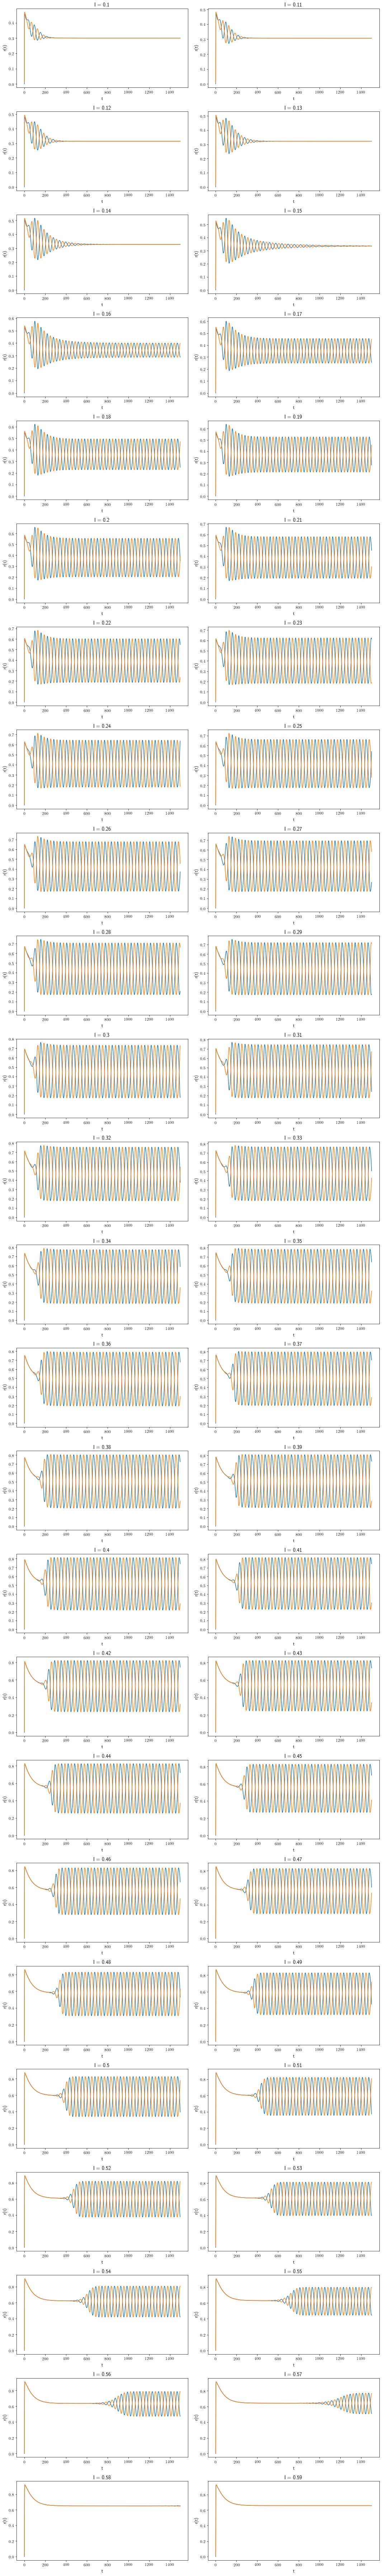

In [12]:
fig, ax = plt.subplots(25, 2)
fig.set_size_inches((15, 100))
for I in range(10, 60):
    r1, r2 = sim3(I/100, I/100, 0.45)
    row = (I - 10) // 2
    col = (I - 10) % 2
    title = 'I = {}'.format(I/100)
    ax[row, col].plot(t, r1)
    ax[row, col].set_xlabel('t')
    ax[row, col].set_ylabel('r(t)')
    ax[row, col].set_title(title)
    ax[row, col].plot(t, r2)
    
fig.tight_layout()

### Fig.4: Rhythmic dynamics. The range of I is approximately (0.16 , 0.58).

# Hopfield Network

## 2a

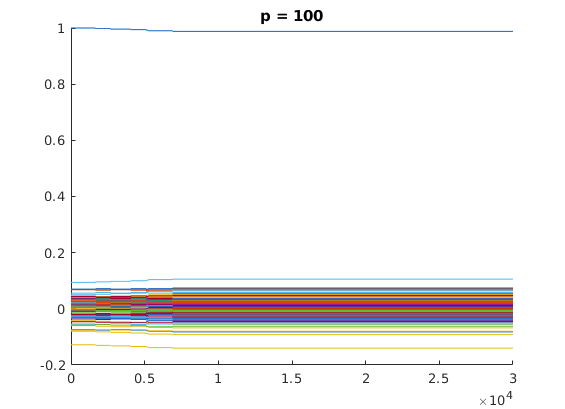

In [6]:
from IPython.display import Image
Image(filename='Fig2.a.1_p=100.png') 

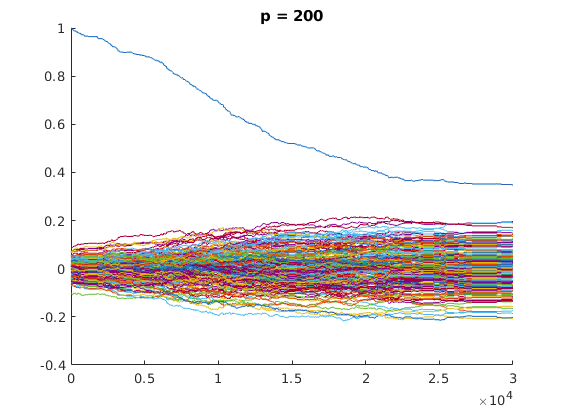

In [7]:
Image(filename='Fig2.a.2_p=200.png') 

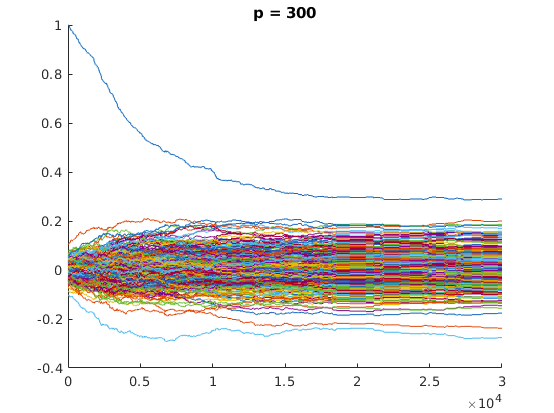

In [8]:
Image(filename='Fig2.a.3_p=300.png') 

### Fig.5: Evolution of coherence, m, with different number of patterns, p. The top blue curve is the pattern to remember. As the number of patterns increases, the coherence degrades more rapidly. The threshold p for perfect coherence is near but smaller than 100. Generated upon modifications on the original Matlab code.

## 2b

In [13]:
@jit([float64(int32, int32)])
def hopfield(p, N):
    #m = np.zeros([num_updates, p]) # m-vector for all patterns
    pattern = np.zeros([N, p]) #create random patterns

    for i in range(p):
        pattern[:, i] = np.random.choice([-1, 1], size=N)
    
    J = np.zeros([N,N]) # connectivivty
    for i in range(p):
        J += np.outer(pattern[:, i], pattern[:, i])

    J /= N
    np.fill_diagonal(J, 0) # set diag to zero

    state = np.copy(pattern[:, 0]) #load in pattern 1

    #update loop
    for t in range(num_updates):
        update_index = int(np.random.uniform(N)) #randomly chosen unit
        h = J[update_index,:] @ state #determine input

        #update state of chosen unit
        if h > 0:
            state[update_index] = 1
        else:
             state[update_index] = -1

        #compute pattern coherence  
        #for i in range(p): 
        m = pattern[:,0] @ state
    m /= N
    return m

In [14]:
N = 1000
num_updates = 30000
ac = 1 / (2 * np.log(N))

In [24]:
def it(N):
    ps = np.array([N * ac * i/10 for i in range(5, 20)], dtype='int32')
    m = np.zeros(ps.shape[0])
    for i, p in enumerate(ps):
        for j in range(10):
            m[i] += hopfield(p, N)
    m /= 10
    return ps/N, m

In [16]:
m = it(N)

Text(0.5, 1.0, '$\\left< m^1(T) \\right>$')

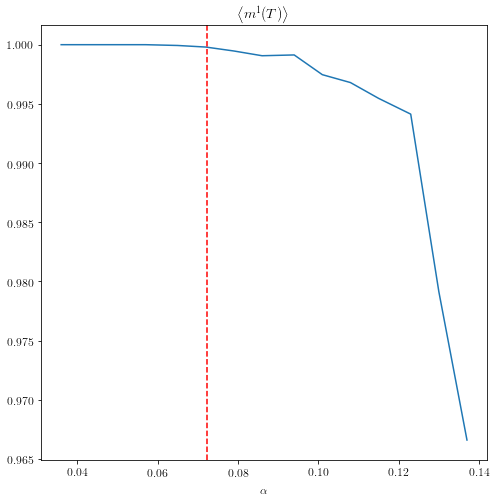

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(*it(N))
plt.axvline(x=ac, color='r', linestyle='--')
plt.xlabel(r'$\alpha$')
plt.title(r'$\left< m^1(T) \right>$')

### Fig.6: Degradation of $\left< m^1 (T) \right>$, the average pattern 1 coherence at T = 30000. The red dash line is $\alpha = \alpha_c$. The coherence starts to degrade when $\alpha > \alpha_c$.

## 2c

In [18]:
num_updates = 30000
ac = 1 / (2 * np.log(N))

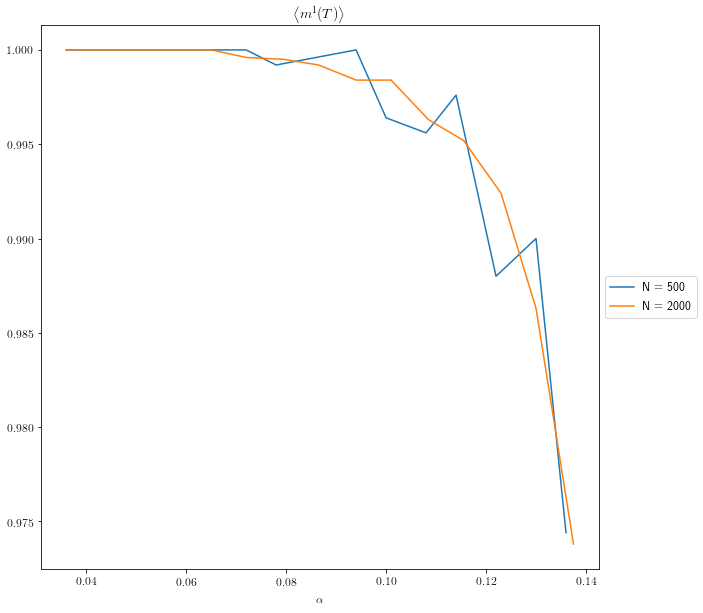

In [25]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((10, 10))

for i, N in enumerate((500, 2000)):
    ax.plot(*it(N), label='N = {}'.format(N))
    ax.set_xlabel(r'$\alpha$')
    ax.set_title(r'$\left< m^1(T) \right>$')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Fig.7: Same average coherence as Fig.6 but with different N. Multiple runs indicate that when N is small, the average coherence tends to display greater fluctuation, i.e. less smoothness in the curve. However, N does not affect the rate of degradation of $\left< m^1 (T) \right>$ explicitly.